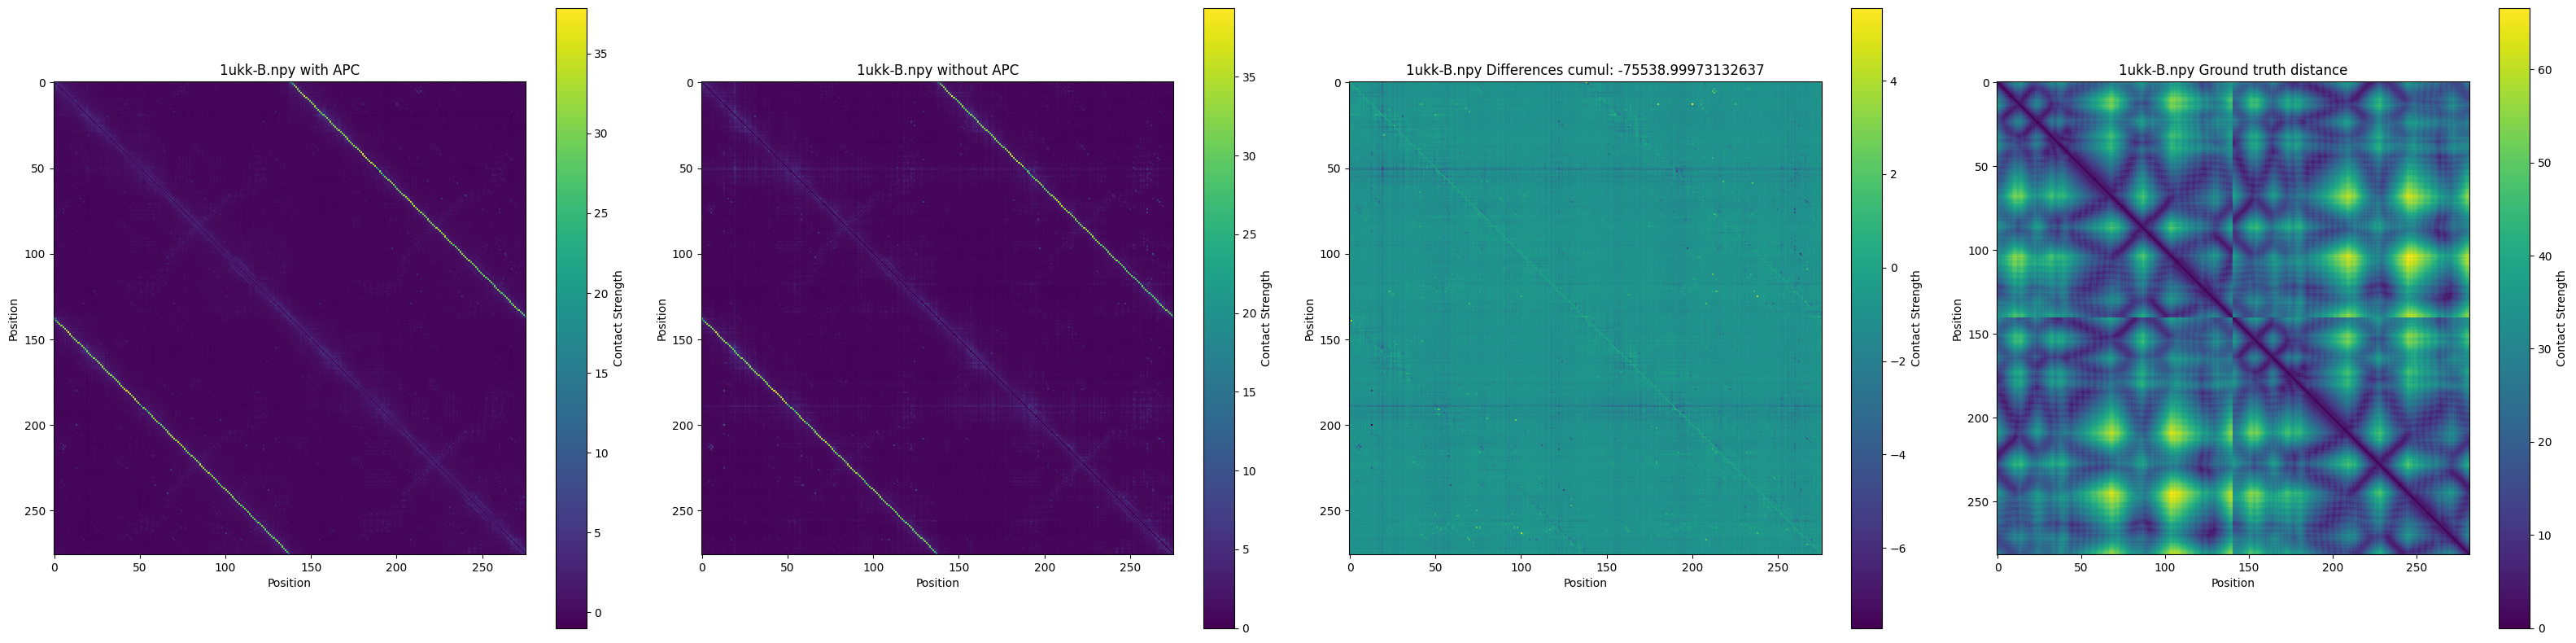

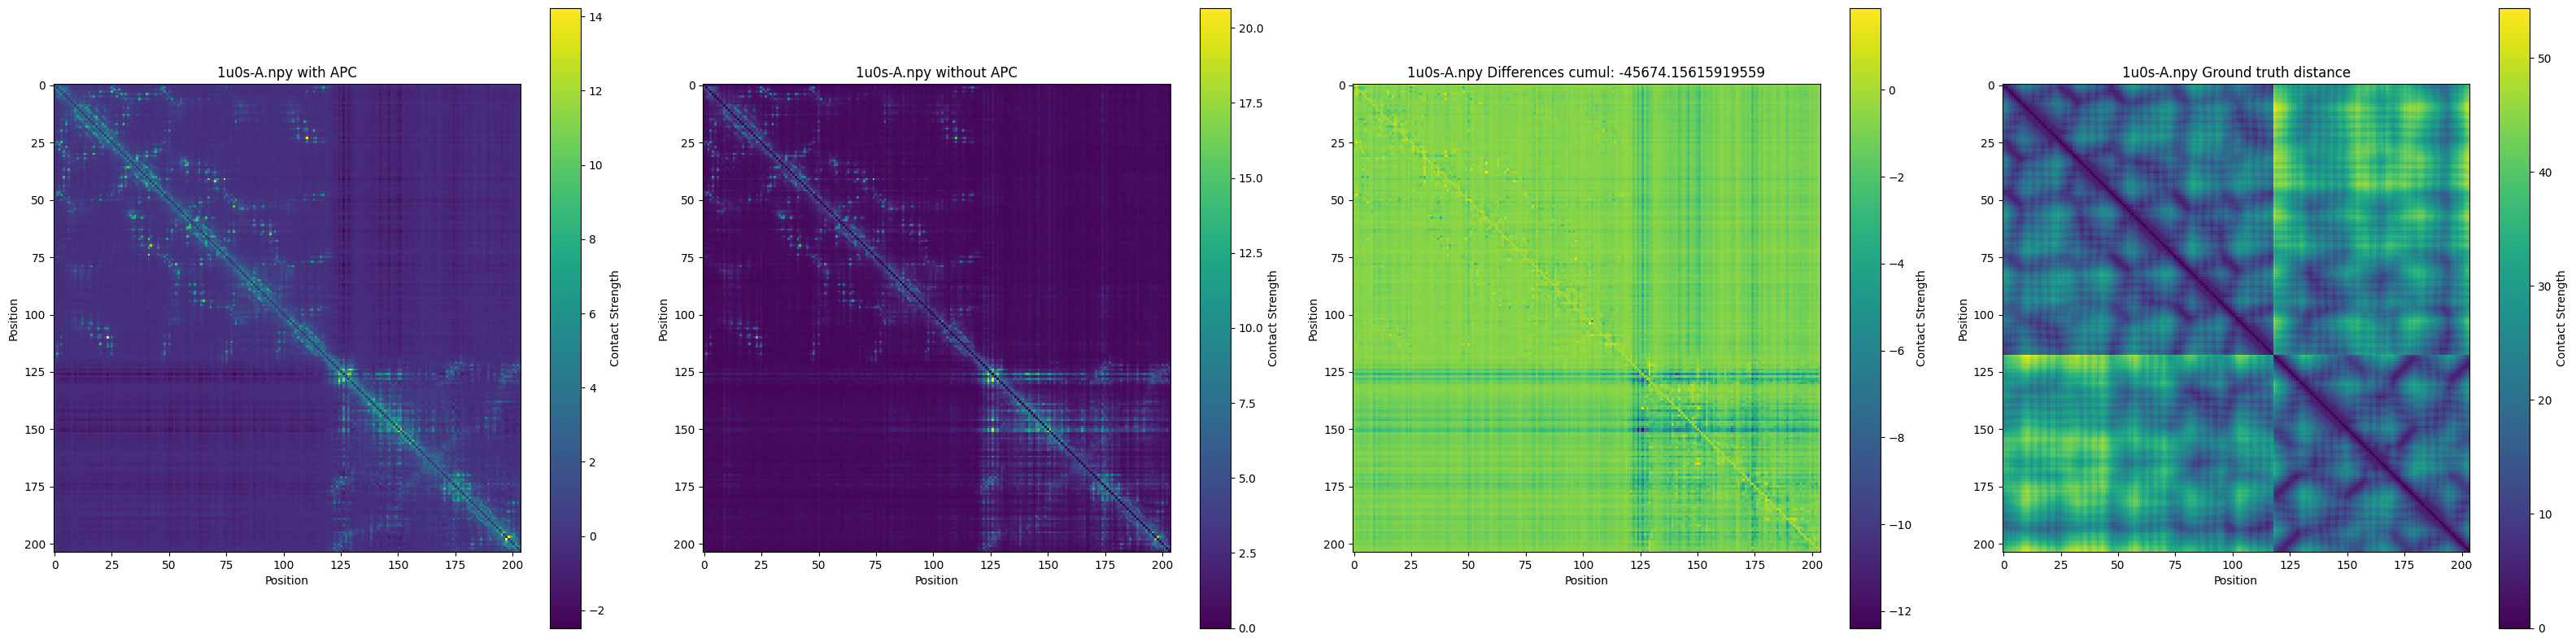

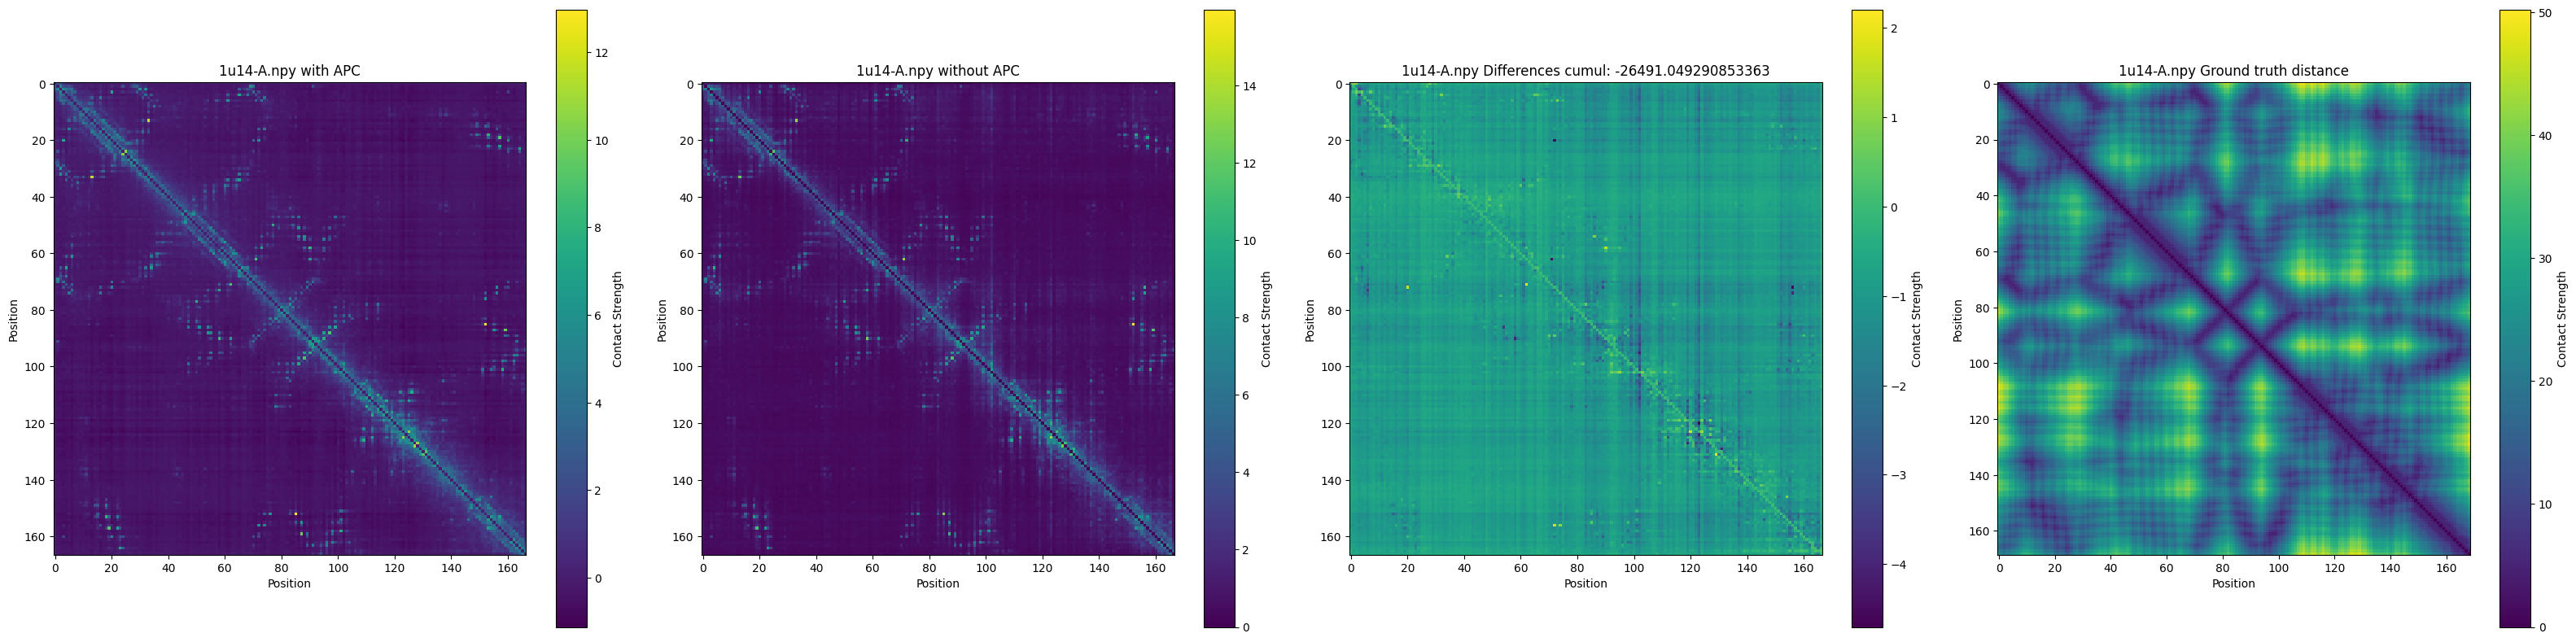

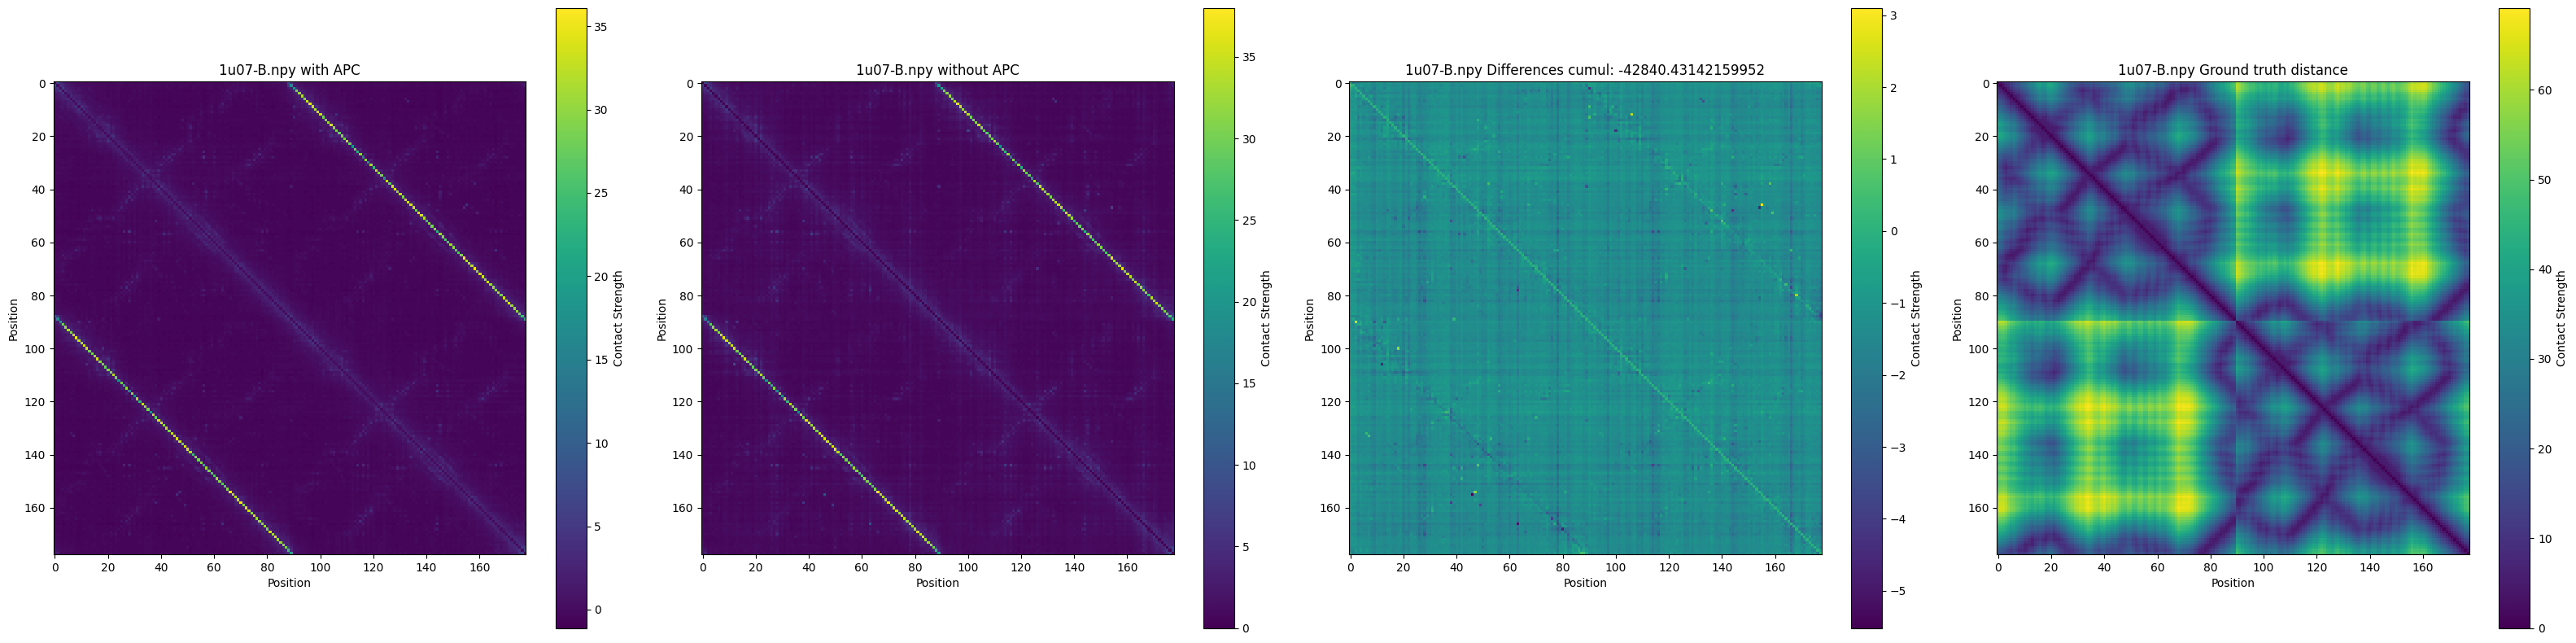

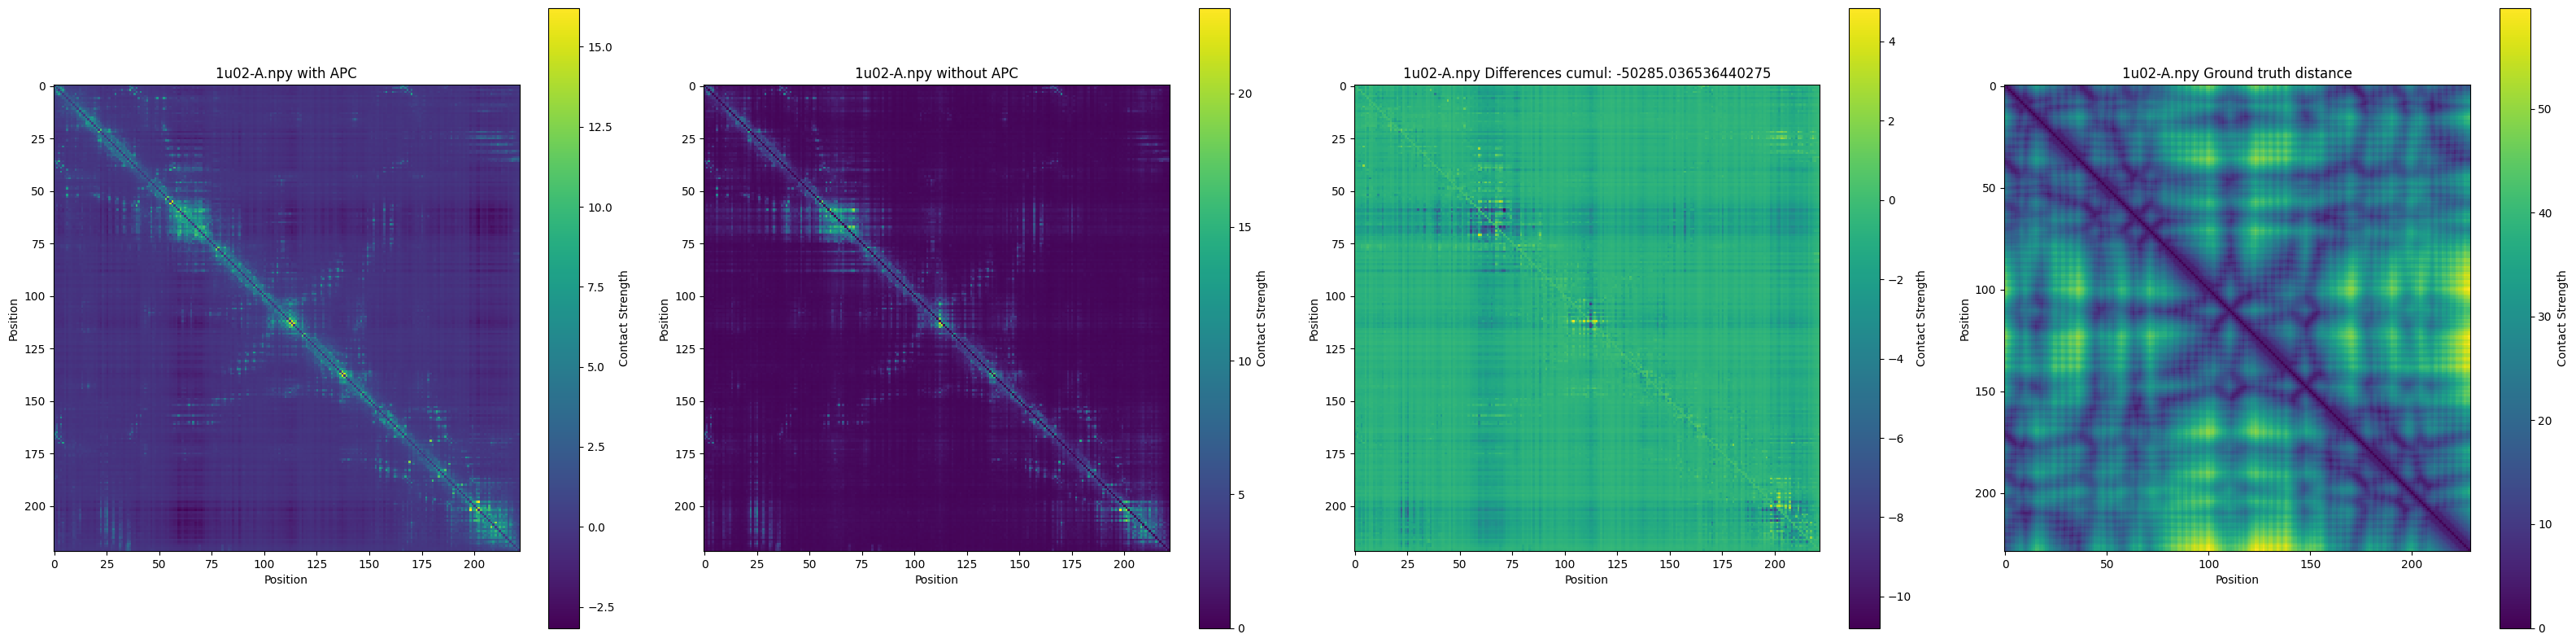

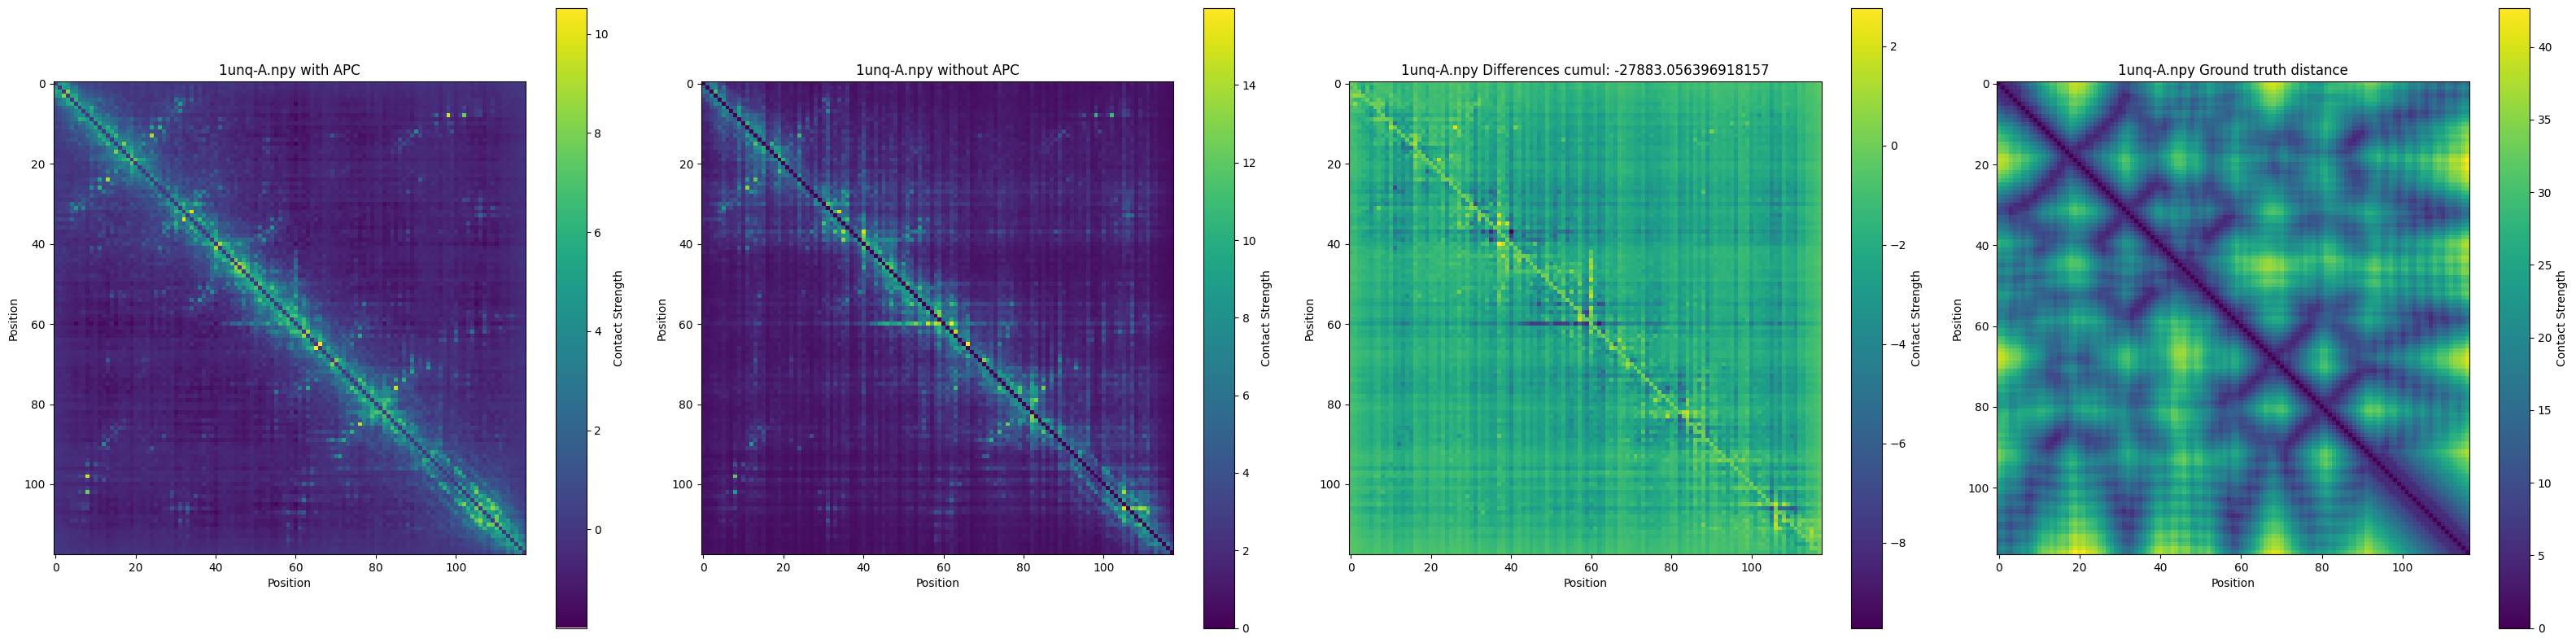

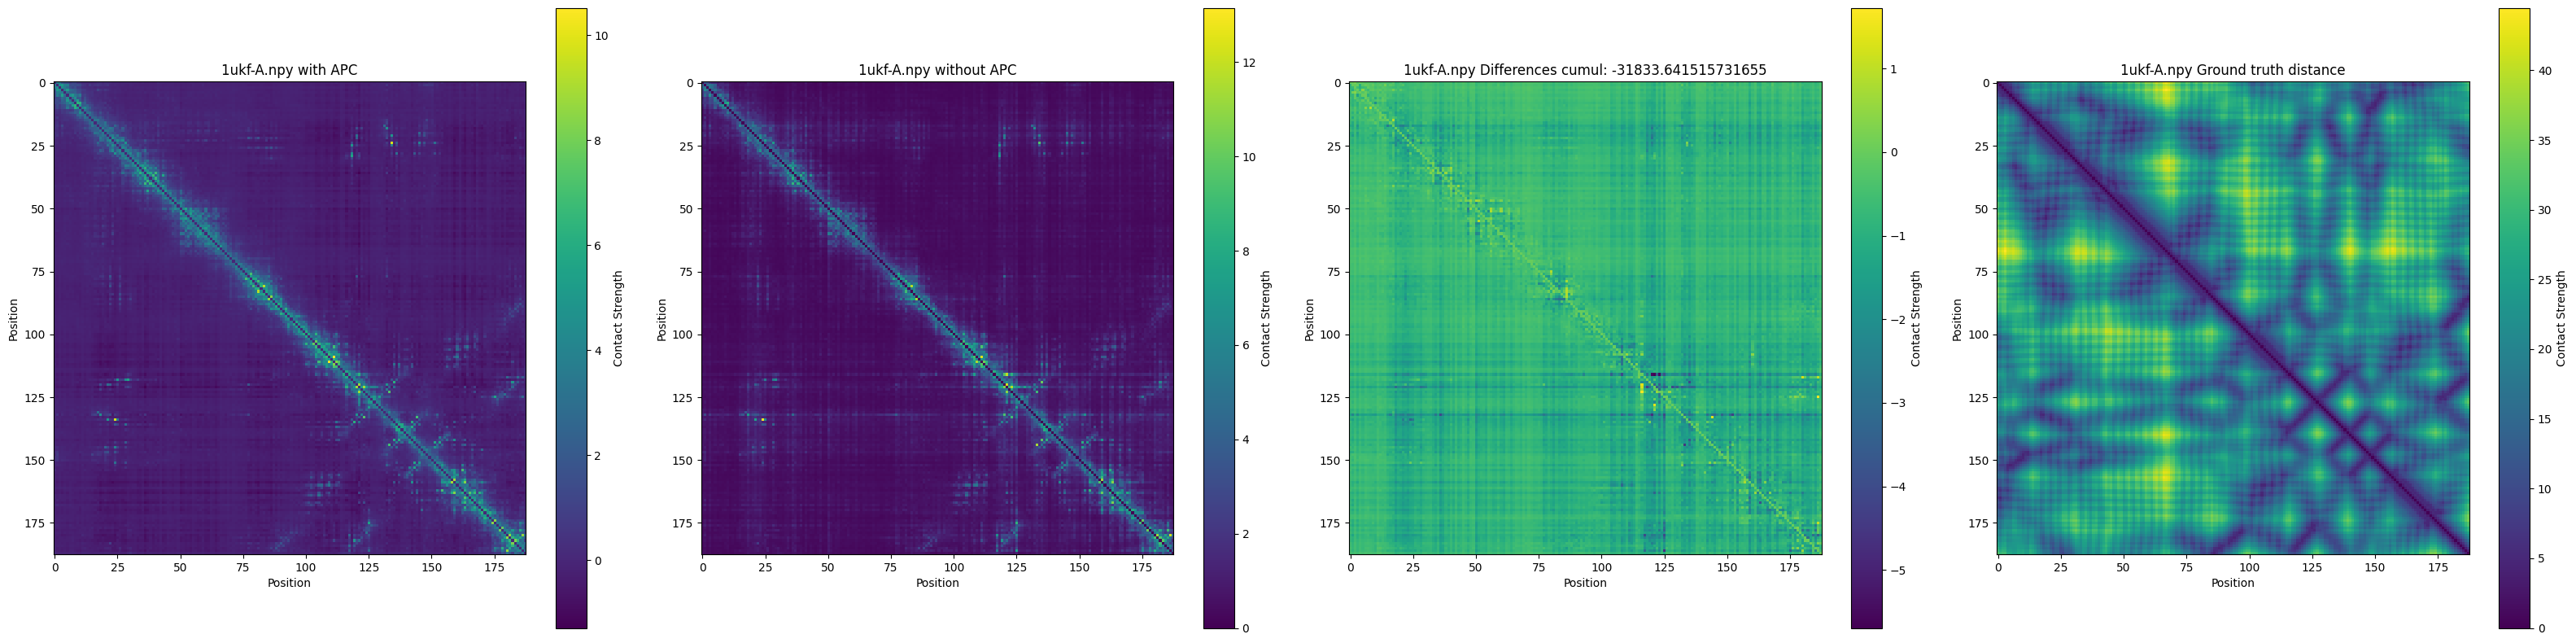

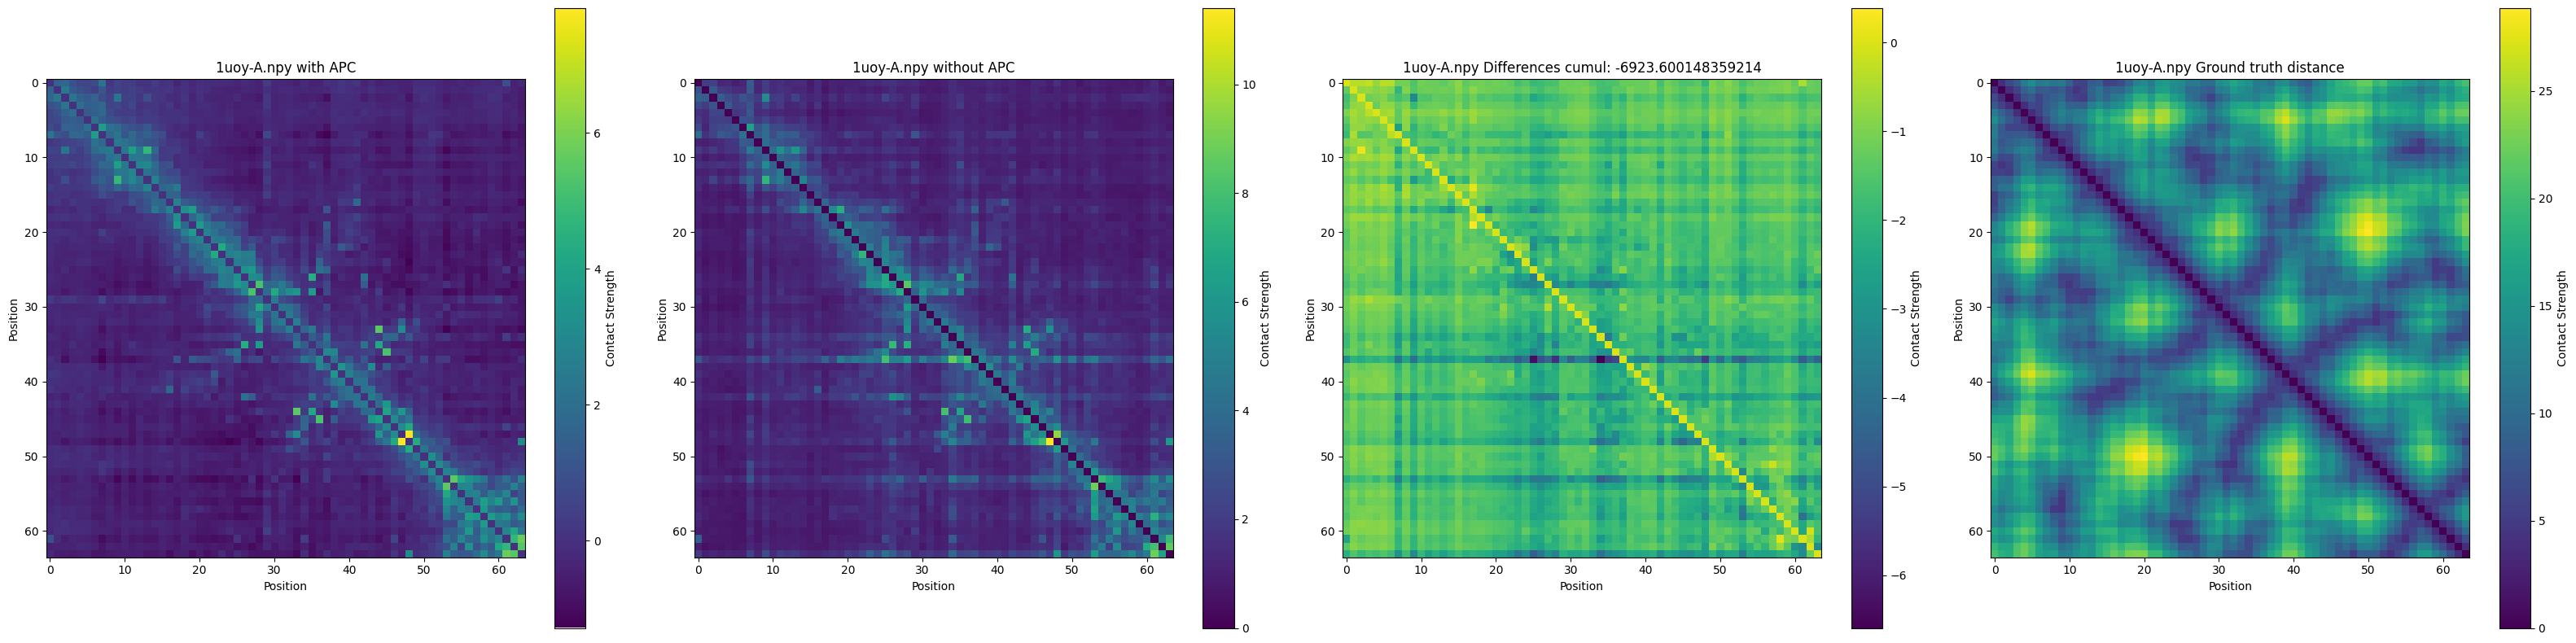

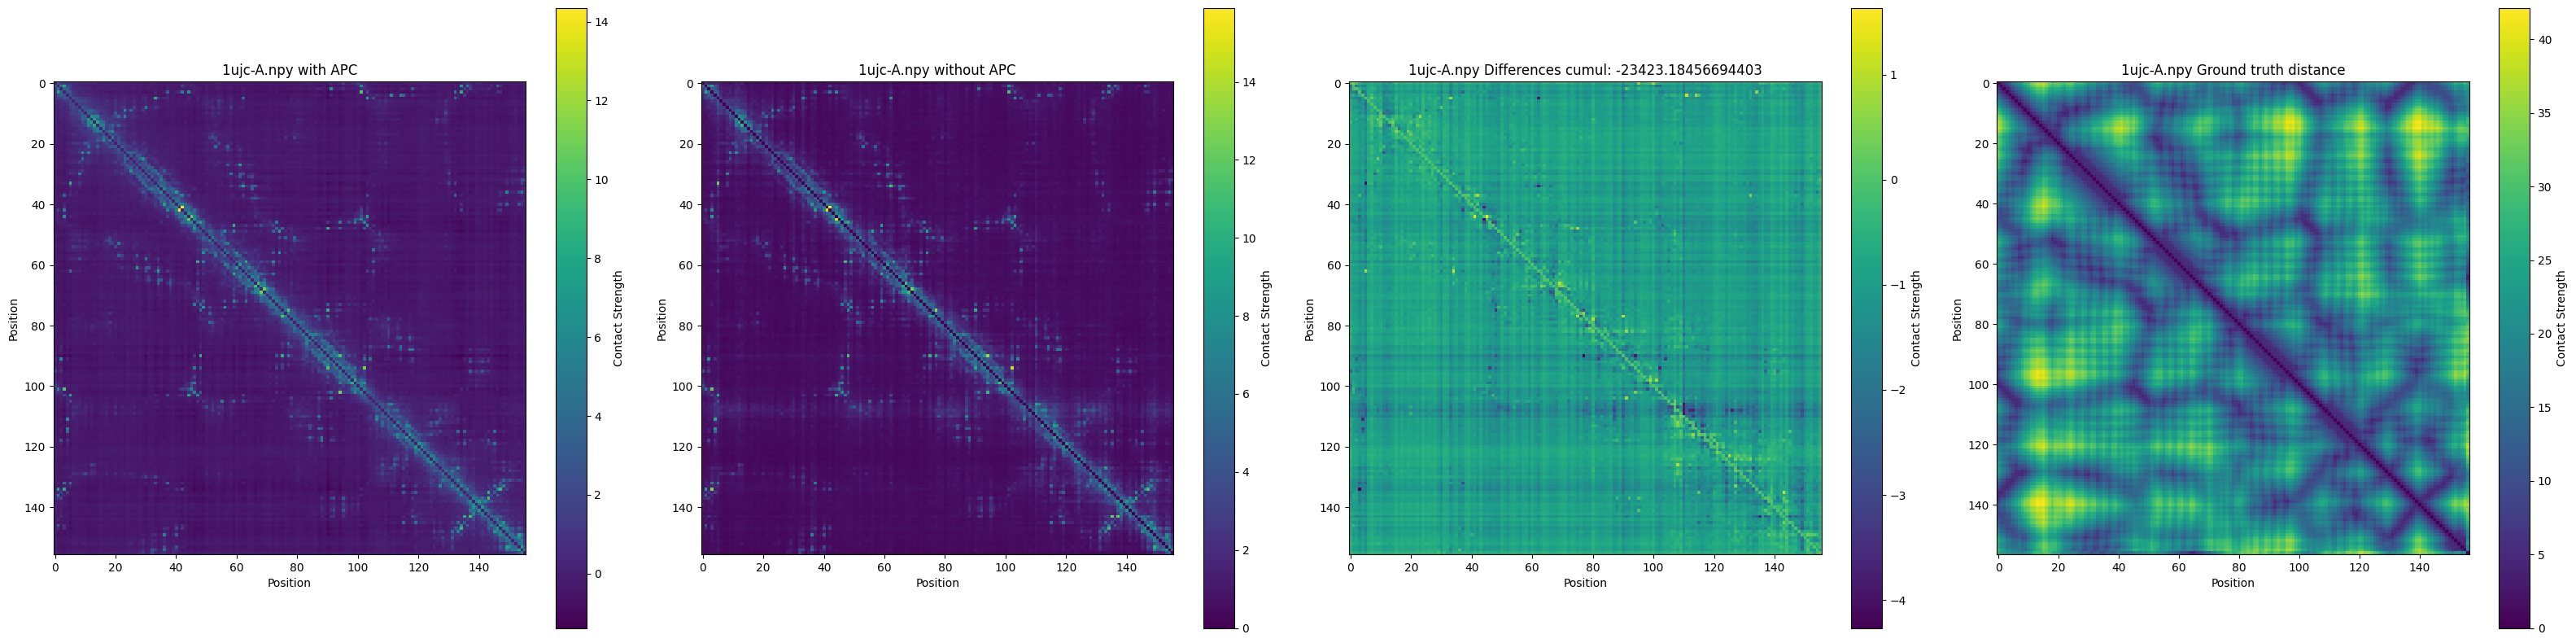

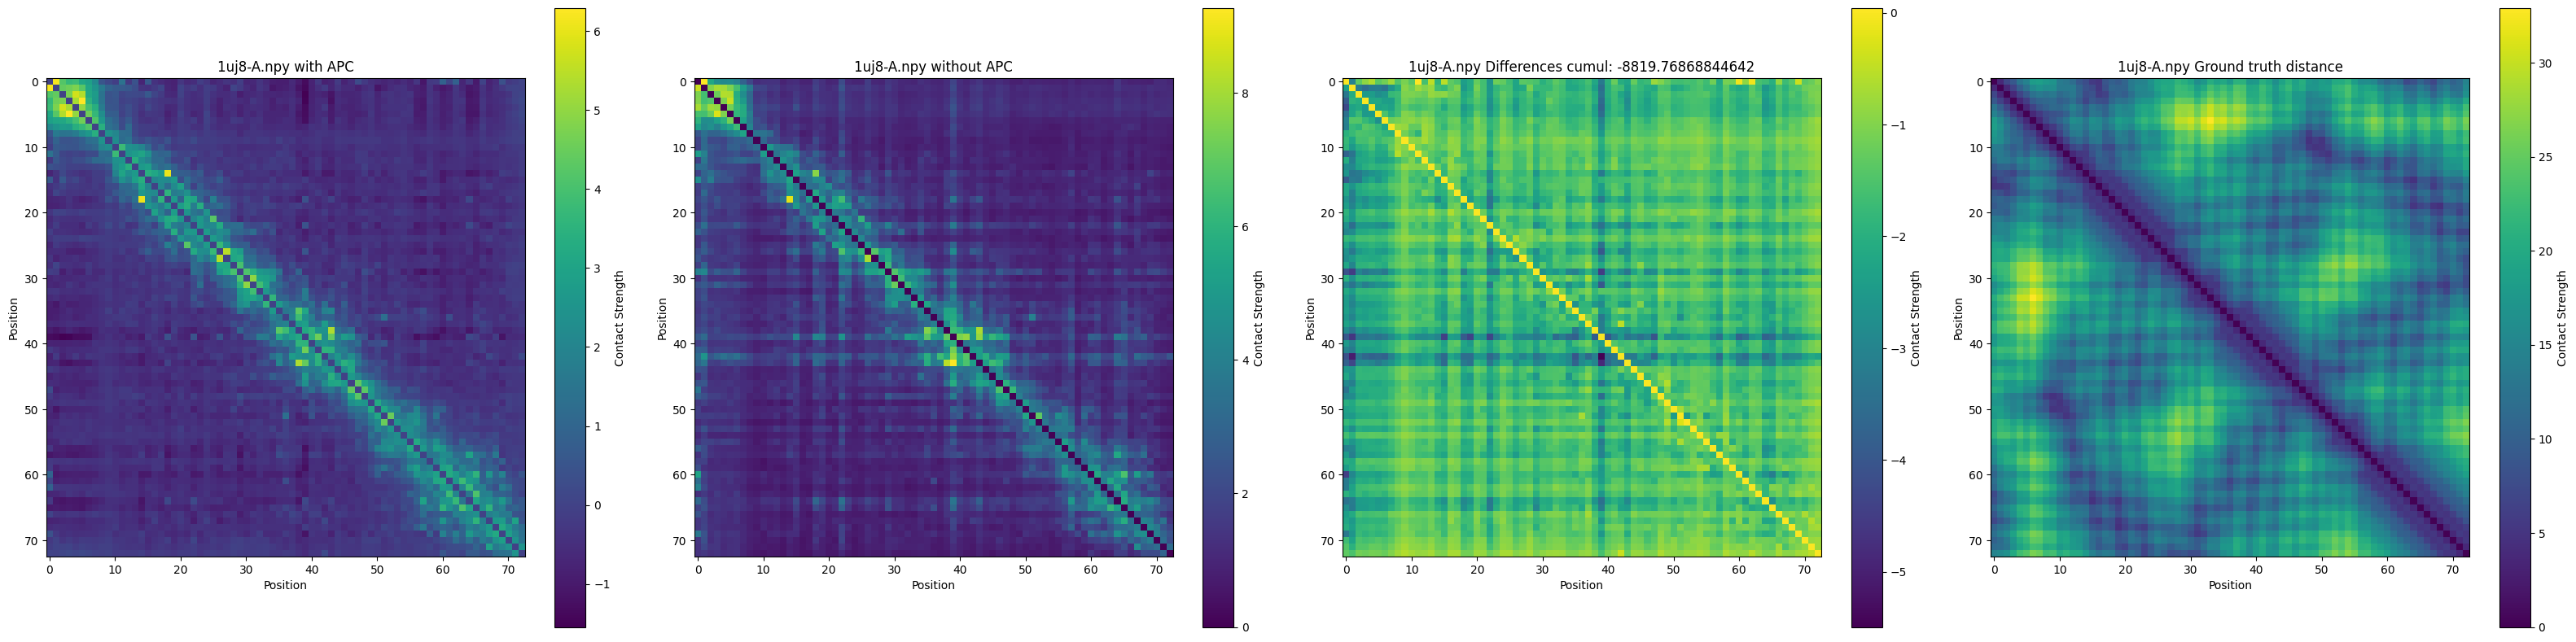

In [37]:
# Plot contact map
# Make the heatmap plot
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_cm(contact_map, ax, title):
    """Plots a contact map on the given axis."""
    ax.imshow(contact_map, cmap="viridis", interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Position")
    ax.set_ylabel("Position")
    cbar = plt.colorbar(ax.imshow(contact_map, cmap="viridis", interpolation="nearest"), ax=ax)
    cbar.set_label("Contact Strength")

def print_diffs(exp_folder="diff_exp/apc_on/"):
    
    files = os.listdir(exp_folder)
    for file in files:
        path_apc = os.path.join(exp_folder, file)
        path_no_apc = os.path.join(exp_folder.replace("apc_on/", "apc_off/"), file)
        # Load the contact maps
        contact_map_with_apc = np.load(path_apc)
        contact_map_without_apc = np.load(path_no_apc)
        difference_map = contact_map_with_apc - contact_map_without_apc
        diff = difference_map.sum()
        
        gt_path = os.path.join(exp_folder.replace("apc_on/", "ground_truth/"), file)
        gt_map = np.load(gt_path)
        
        # Plot the difference
#         fig, ax = plt.subplots(figsize=(8, 8))
#         cax = ax.imshow(difference_map, cmap="coolwarm", interpolation="nearest")
#         ax.set_title("Difference: With APC - Without APC")
#         ax.set_xlabel("Position")
#         ax.set_ylabel("Position")
#         cbar = plt.colorbar(cax, ax=ax)
#         cbar.set_label("Difference in Contact Strength")

#         plt.tight_layout()
#         plt.show()
        # Create the side-by-side plots
        fig, axs = plt.subplots(1, 4, figsize=(32, 8))
        plot_cm(contact_map_with_apc, axs[0], f"{file} with APC")
        plot_cm(contact_map_without_apc, axs[1], f"{file} without APC")
        plot_cm(difference_map, axs[2], f"{file} Differences cumul: {diff}")
        plot_cm(gt_map, axs[3], f"{file} Ground truth distance")
        

        plt.tight_layout()
        
        plt.savefig(f"{file}_apc_experiment.png")
        plt.show()

        
def plot_side_by_side():
    pass
    
print_diffs()

# Calculate Ground truths

In [24]:
import numpy as np
from Bio import PDB

def calculate_contact_map_binary(pdb_file, cutoff=8.0):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize contact map
    contact_map = np.zeros((sequence_length, sequence_length), dtype=int)
    
    # Calculate distances and populate contact map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            if distance <= cutoff:
                contact_map[i, j] = 1
                contact_map[j, i] = 1  # Symmetric matrix

    return contact_map

def calculate_distance_map(pdb_file):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize distance map
    distance_map = np.zeros((sequence_length, sequence_length), dtype=float)
    
    # Calculate distances and populate distance map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            distance_map[i, j] = distance
            distance_map[j, i] = distance  # Symmetric matrix

    return distance_map

In [29]:
folder = "pdbs/"
files = os.listdir(folder)

for file in files:
    dm = calculate_distance_map(os.path.join(folder, file))
    np.save(f"diff_exp/ground_truth/{file.replace('.pdb', '.npy')}", dm)